In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import seaborn as sns



In [2]:
# Étape 1 : Préparation des données
file_path = 'Transfert_ new.csv'
transfert_data = pd.read_csv(file_path, sep=';')
transfert_data.columns = transfert_data.columns.str.strip().str.replace('ï»¿', '')

#  Conversion de la colonne des dates en format datetime
transfert_data['dou'] = pd.to_datetime(transfert_data['dou'], format='%d/%m/%Y')

# Calcul des caractéristiques pertinentes pour chaque ordonnateur, y compris le nombre de devises
features = transfert_data.groupby('nomdo').agg(
    montant_total=('mcfa', 'sum'),
    montant_moyen=('mcfa', 'mean'),
    nombre_transferts=('mcfa', 'count'),
    annee_active=('dou', lambda x: x.dt.year.nunique()),
    nombre_devises=('dev', lambda x: x.nunique())
).reset_index()


In [20]:
# Étape 2 : Standardisation des données
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features[['montant_total', 'montant_moyen', 'nombre_transferts', 'annee_active', 'nombre_devises']])

# Application de DBSCAN pour le clustering
dbscan = DBSCAN(eps=1, min_samples=5)  # Ajuster eps et min_samples selon les besoins
clusters = dbscan.fit_predict(scaled_features)
features['Cluster'] = clusters

In [21]:
# Calcul des statistiques des clusters
cluster_stats = features[features['Cluster'] != -1].groupby('Cluster').agg({
    'montant_total': ['mean', 'sum'],
    'montant_moyen': ['mean'],
    'nombre_transferts': ['mean', 'sum'],
    'annee_active': ['mean'],
    'nombre_devises': ['mean'],
    'Cluster': 'size'
}).rename(columns={'Cluster': 'count'})

# Affichage des statistiques des clusters pour analyser et attribuer des noms pertinents
print(cluster_stats)

        montant_total               montant_moyen nombre_transferts         \
                 mean           sum          mean              mean    sum   
Cluster                                                                      
0        1.019505e+09  7.330239e+11  6.434635e+07         20.022253  14396   
1        4.108265e+09  2.013050e+12  5.176098e+07         92.924490  45533   
2        6.615863e+09  1.078386e+12  3.799464e+07        198.656442  32381   
3        4.924053e+09  1.083292e+11  3.066595e+07        174.045455   3829   
4        4.678449e+09  2.339224e+10  1.811642e+07        207.200000   1036   
5        1.758987e+10  1.055392e+11  1.784722e+07        988.000000   5928   

        annee_active nombre_devises count  
                mean           mean  size  
Cluster                                    
0           2.369958            1.0   719  
1           3.979592            2.0   490  
2           4.809816            3.0   163  
3           4.681818            4

In [22]:
# Renommer les clusters en fonction des caractéristiques observées et ajouter des commentaires
cluster_names = {
    0: 'Prospect',  # Montant modéré, nombre de transferts bas, années actives faibles
    1: 'Client Régulier',  # Montant total et moyen modérés, nombre moyen de devises, activité élevée
    2: 'Client Fidèle',  # Montant total et moyen élevés, nombre élevé de devises, activité très élevée
    3: 'Client Diversifié',  # Montant total et moyen élevés, nombre très élevé de devises, activité très élevée
    4: 'Client Premium',  # Montant total et moyen très élevés, nombre extrêmement élevé de devises, activité maximale
    5: 'Grand Client',  # Montant total et moyen extrêmement élevés, nombre élevé de devises, activité maximale
    -1: 'Outliers'  # Données aberrantes
}

features['Cluster_Name'] = features['Cluster'].map(cluster_names)



C:\Users\user\AppData\Local\Temp\ipykernel_12392\2613771313.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_10_ordonnateurs = features[features['Cluster'] != -1].groupby('Cluster_Name').apply(lambda x: x.nlargest(15, 'montant_total')).reset_index(drop=True)


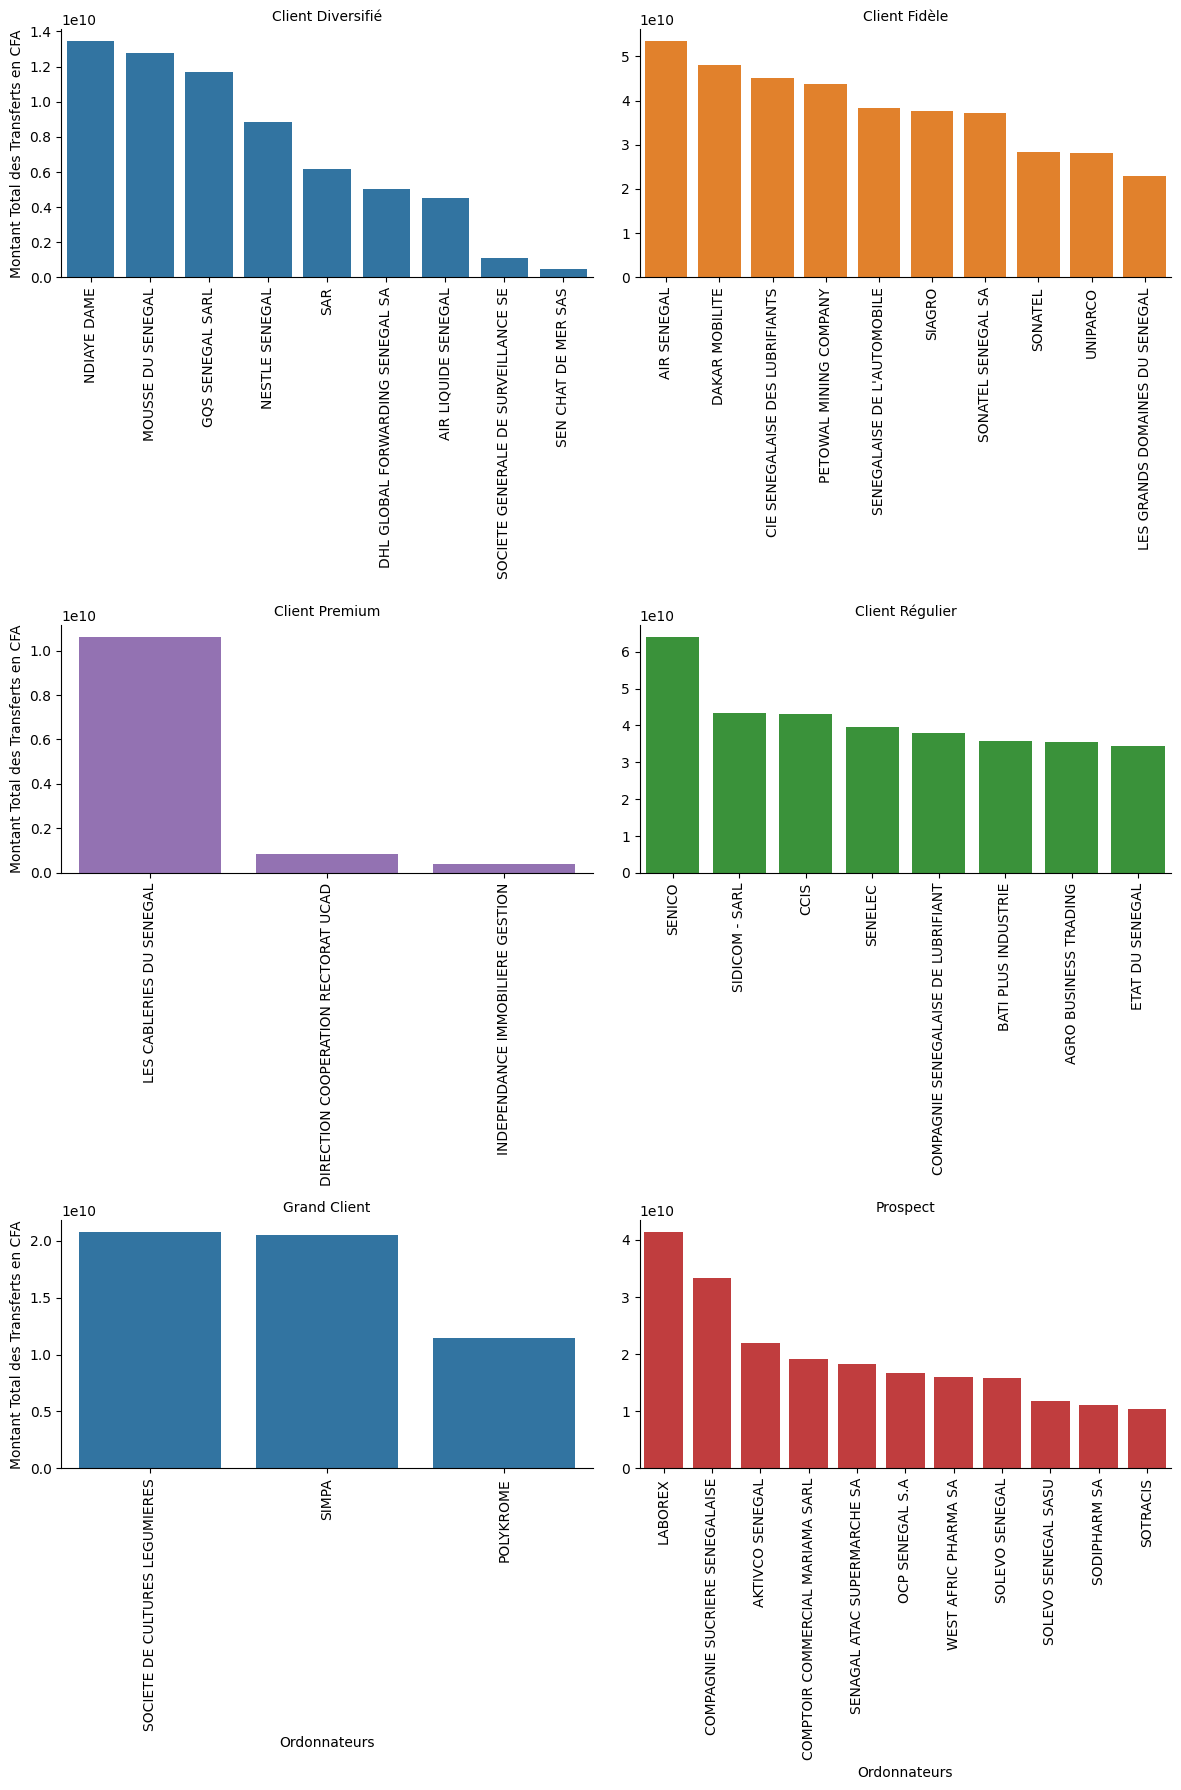

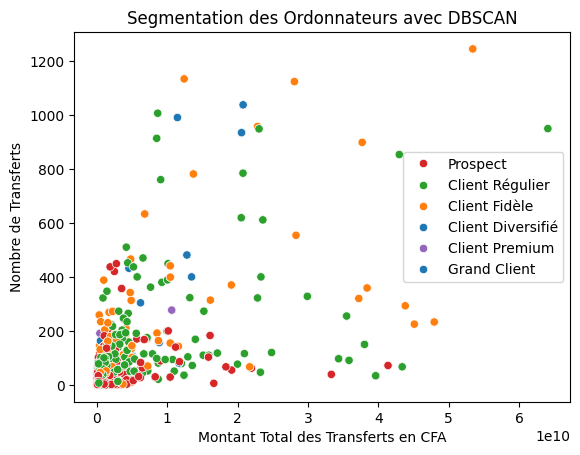

C:\Users\user\AppData\Local\Temp\ipykernel_12392\2613771313.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='nomdo', y='mcfa', data=top_10_transferts, palette='viridis')


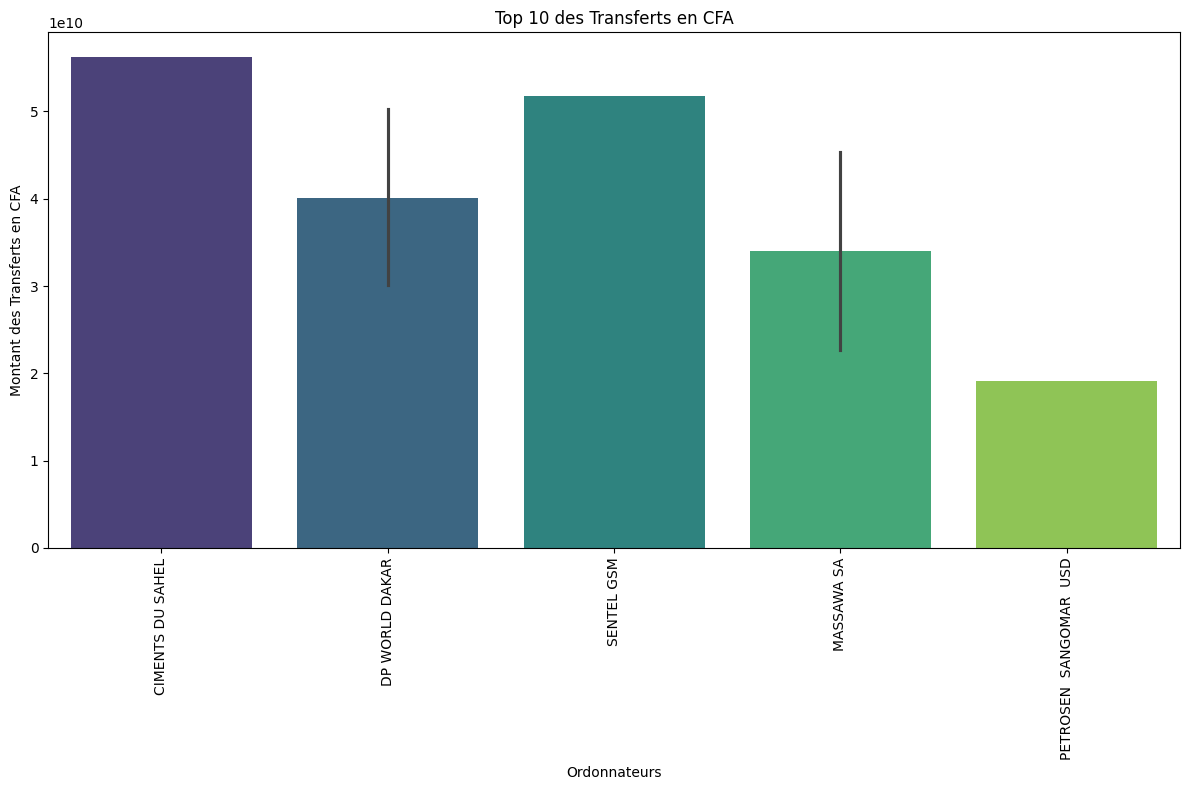

: 

In [23]:
# Identification des top 10 ordonnateurs de chaque segment
top_10_ordonnateurs = features[features['Cluster'] != -1].groupby('Cluster_Name').apply(lambda x: x.nlargest(15, 'montant_total')).reset_index(drop=True)

# Utilisation de couleurs distinctes pour chaque segment
palette = {
    'Prospect': 'tab:red',
    'Client Fidèle': 'tab:orange',
    'Client Régulier': 'tab:green',
    'Client Diversifié': 'tab:blue',
    'Client Premium': 'tab:purple',
    'Grand Client': 'tab:blue'
}

# Visualisation des top 10 ordonnateurs de chaque segment
g = sns.FacetGrid(top_10_ordonnateurs, col="Cluster_Name", col_wrap=2, sharex=False, sharey=False, height=6, palette=palette)
g.map_dataframe(sns.barplot, x='nomdo', y='montant_total', hue='Cluster_Name', palette=palette, dodge=False)
g.set_axis_labels("Ordonnateurs", "Montant Total des Transferts en CFA")
g.set_titles("{col_name}")
g.set_xticklabels(rotation=90)
plt.tight_layout()
plt.show()

# Visualisation des segments avec couleurs distinctes
sns.scatterplot(data=features[features['Cluster'] != -1], x='montant_total', y='nombre_transferts', hue='Cluster_Name', palette=palette)
plt.xlabel('Montant Total des Transferts en CFA')
plt.ylabel('Nombre de Transferts')
plt.title('Segmentation des Ordonnateurs avec DBSCAN')
plt.legend()
plt.show()

# Visualisation du top 10 des transferts en termes de montant total en CFA
plt.figure(figsize=(12, 8))
top_10_transferts = transfert_data.nlargest(10, 'mcfa')
sns.barplot(x='nomdo', y='mcfa', data=top_10_transferts, palette='viridis')
plt.xlabel('Ordonnateurs')
plt.ylabel('Montant des Transferts en CFA')
plt.title('Top 10 des Transferts en CFA')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()



In [7]:
# Ajouter le nom du gestionnaire
#features = features.merge(transfert_data[['cli', 'nomdo']].drop_duplicates(), on='nomdo', how='left')

# Sauvegarder le fichier Excel
#output_file_path = 'Client_Segmentation_DBSCAN_new1.xlsx'
#features.to_excel(output_file_path, index=False)

#print(f"Le fichier Excel a été sauvegardé sous : {output_file_path}")

In [8]:
from sklearn.metrics import silhouette_score

# Filtrer les outliers (cluster -1)
filtered_features = features[features['Cluster'] != -1]
filtered_scaled_features = scaled_features[filtered_features.index]

# Calcul du coefficient de silhouette
silhouette_avg = silhouette_score(filtered_scaled_features, filtered_features['Cluster'])
print(f"Le coefficient de silhouette moyen pour DBSCAN est : {silhouette_avg:.2f}")


Le coefficient de silhouette moyen pour DBSCAN est : 0.43


In [9]:
from sklearn.metrics import v_measure_score, completeness_score, homogeneity_score

# Calcul des métriques de clustering
v_measure = v_measure_score(filtered_features['Cluster'], filtered_features['Cluster'])
completeness = completeness_score(filtered_features['Cluster'], filtered_features['Cluster'])
homogeneity = homogeneity_score(filtered_features['Cluster'], filtered_features['Cluster'])

print(f"V-mesure: {v_measure:.2f}")
print(f"Complétude: {completeness:.2f}")
print(f"Homogénéité: {homogeneity:.2f}")


V-mesure: 1.00
Complétude: 1.00
Homogénéité: 1.00


In [10]:
# Calcul du nombre total de clients uniques
nombre_total_clients = features['nomdo'].nunique()

print(f"Le nombre total de clients est : {nombre_total_clients}")


Le nombre total de clients est : 1185


Analyse Temporelle

In [11]:
# Ajouter une colonne année
transfert_data['année'] = transfert_data['dou'].dt.year

# Calculer la somme des flux par année pour chaque client
flux_annuels = transfert_data.groupby(['nomdo', 'année'])['mcfa'].sum().reset_index()

# Calculer la tendance (slope) des flux pour chaque client
flux_annuels_pivot = flux_annuels.pivot(index='nomdo', columns='année', values='mcfa').fillna(0)
slopes = flux_annuels_pivot.apply(lambda x: pd.Series({'slope': x.diff().mean()}), axis=1).reset_index()

# Trier les clients par tendance des flux
slopes_sorted = slopes.sort_values(by='slope')


In [12]:
# Top 10 clients avec la plus grande diminution des flux
top_10_decreasing = slopes_sorted.head(20)

# Top 10 clients avec la plus grande augmentation des flux
top_10_increasing = slopes_sorted.tail(20)

# Affichage des résultats
print("Top 10 clients avec la plus grande diminution des flux :")
print(top_10_decreasing)

print("\nTop 10 clients avec la plus grande augmentation des flux :")
print(top_10_increasing)


Top 10 clients avec la plus grande diminution des flux :
                                nomdo         slope
1131                    TOTAL SENEGAL -2.425375e+10
922                        SENTEL GSM -1.036412e+10
766            PETOWAL MINING COMPANY -8.751040e+09
45                        AIR SENEGAL -8.207565e+09
376                    DP WORLD DAKAR -5.983163e+09
843          SABODALA GOLD OPERATIONS -4.438065e+09
246   CIE SENEGALAISE DES LUBRIFIANTS -3.270545e+09
902       SENAGAL ATAC SUPERMARCHE SA -3.088506e+09
679                     METAL AFRIQUE -3.083484e+09
765                           PATISEN -2.109180e+09
1014                     SODIPHARM SA -1.883852e+09
378                          DUOPHARM -1.873852e+09
656      MAN ENERGY SOLUTIONS SENEGAL -1.376757e+09
223                              CCIS -1.327045e+09
870                         SAUDEQUIP -1.211488e+09
434                   ETAT DU SENEGAL -1.154477e+09
160               BATI PLUS INDUSTRIE -1.123491e+09
1019   

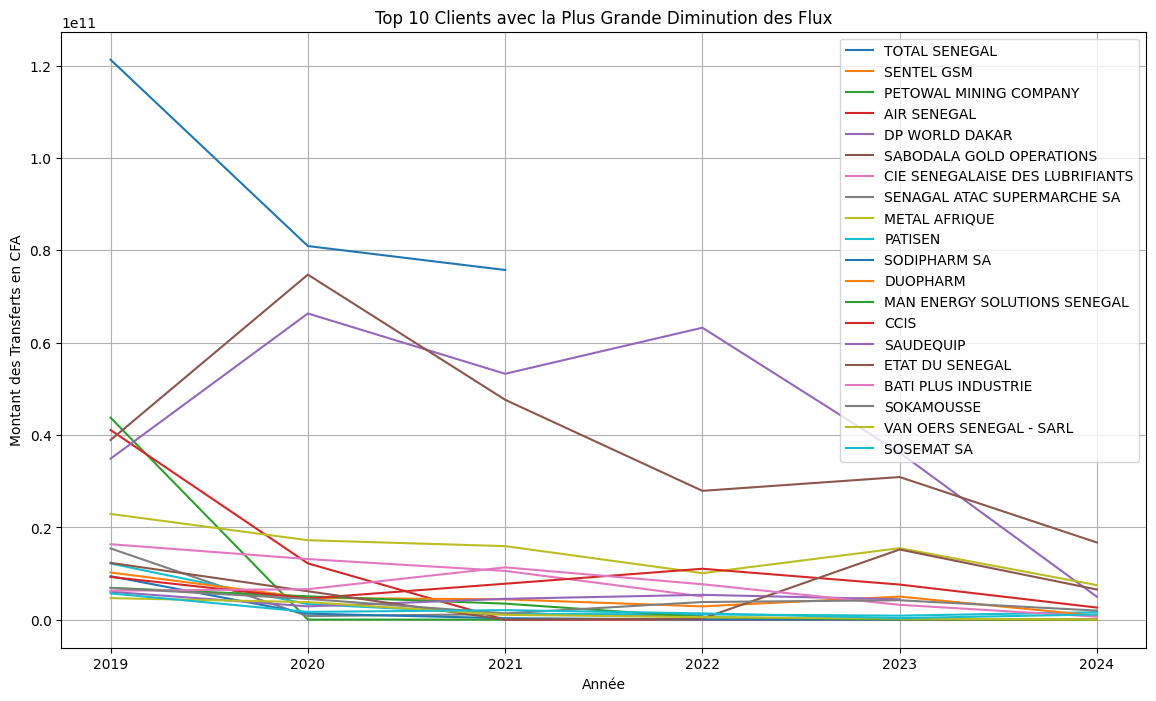

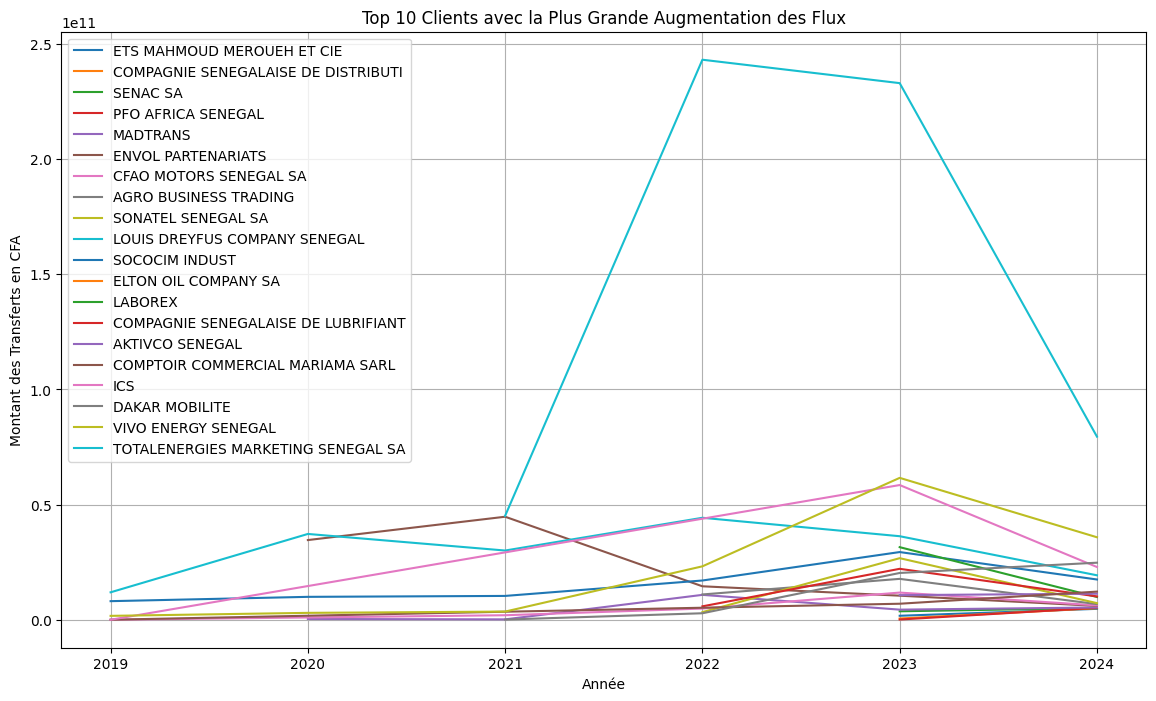

In [13]:
# Préparer les données pour les graphiques
top_10_decreasing_clients = top_10_decreasing['nomdo'].tolist()
top_10_increasing_clients = top_10_increasing['nomdo'].tolist()

flux_annuels_decreasing = flux_annuels[flux_annuels['nomdo'].isin(top_10_decreasing_clients)]
flux_annuels_increasing = flux_annuels[flux_annuels['nomdo'].isin(top_10_increasing_clients)]

# Graphique pour les clients avec la plus grande diminution des flux
plt.figure(figsize=(14, 8))
for client in top_10_decreasing_clients:
    client_data = flux_annuels_decreasing[flux_annuels_decreasing['nomdo'] == client]
    plt.plot(client_data['année'], client_data['mcfa'], label=client)
plt.xlabel('Année')
plt.ylabel('Montant des Transferts en CFA')
plt.title('Top 10 Clients avec la Plus Grande Diminution des Flux')
plt.legend()
plt.grid(True)
plt.show()

# Graphique pour les clients avec la plus grande augmentation des flux
plt.figure(figsize=(14, 8))
for client in top_10_increasing_clients:
    client_data = flux_annuels_increasing[flux_annuels_increasing['nomdo'] == client]
    plt.plot(client_data['année'], client_data['mcfa'], label=client)
plt.xlabel('Année')
plt.ylabel('Montant des Transferts en CFA')
plt.title('Top 10 Clients avec la Plus Grande Augmentation des Flux')
plt.legend()
plt.grid(True)
plt.show()


cluster
0    1175
3       7
2       1
4       1
1       1
Name: count, dtype: int64


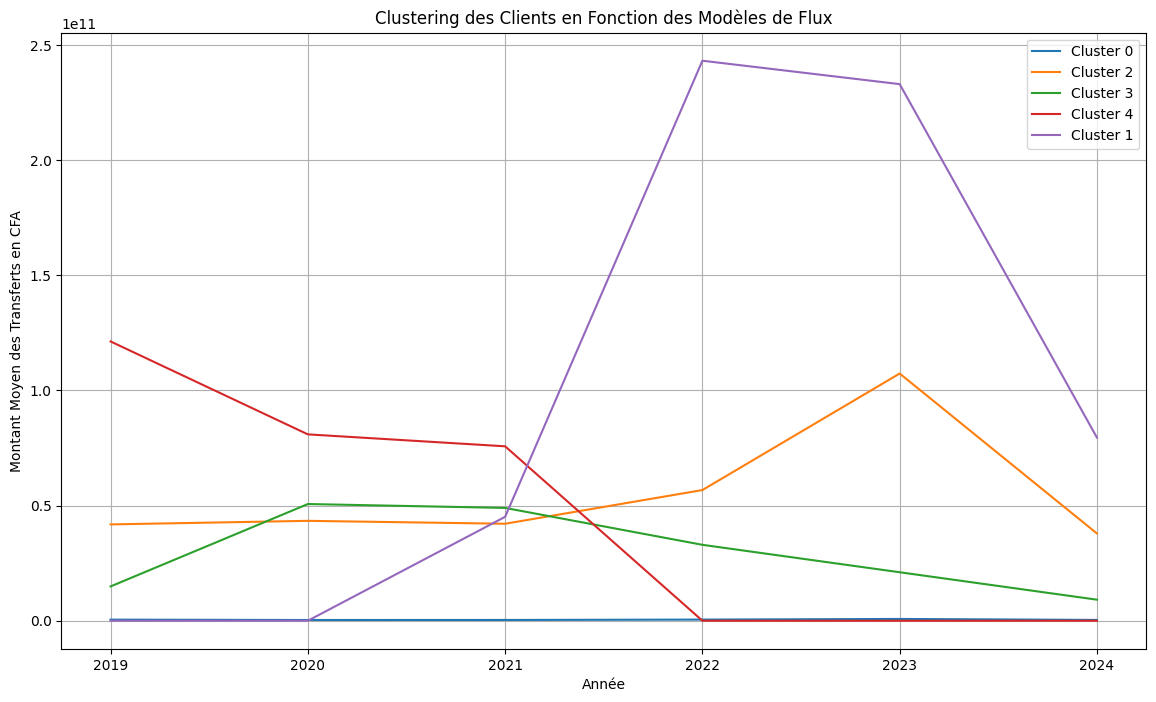

In [14]:
from sklearn.cluster import KMeans

# Pivot pour obtenir une matrice de clients x années
flux_annuels_matrix = flux_annuels.pivot(index='nomdo', columns='année', values='mcfa').fillna(0)

# Utiliser la matrice de flux annuels pour le clustering
kmeans = KMeans(n_clusters=5, random_state=42)
flux_annuels_matrix['cluster'] = kmeans.fit_predict(flux_annuels_matrix)

# Afficher les clients dans chaque cluster
print(flux_annuels_matrix['cluster'].value_counts())

# Visualisation des clusters
plt.figure(figsize=(14, 8))
for cluster in flux_annuels_matrix['cluster'].unique():
    cluster_data = flux_annuels_matrix[flux_annuels_matrix['cluster'] == cluster].mean()
    plt.plot(cluster_data.index[:-1], cluster_data.values[:-1], label=f'Cluster {cluster}')
plt.xlabel('Année')
plt.ylabel('Montant Moyen des Transferts en CFA')
plt.title('Clustering des Clients en Fonction des Modèles de Flux')
plt.legend()
plt.grid(True)
plt.show()


In [15]:
# Identifier les top 10 clients de chaque cluster
top_10_clients_per_cluster = {}
for cluster in flux_annuels_matrix['cluster'].unique():
    cluster_data = flux_annuels_matrix[flux_annuels_matrix['cluster'] == cluster]
    top_10_clients = cluster_data.mean(axis=1).nlargest(10).index.tolist()
    top_10_clients_per_cluster[cluster] = top_10_clients


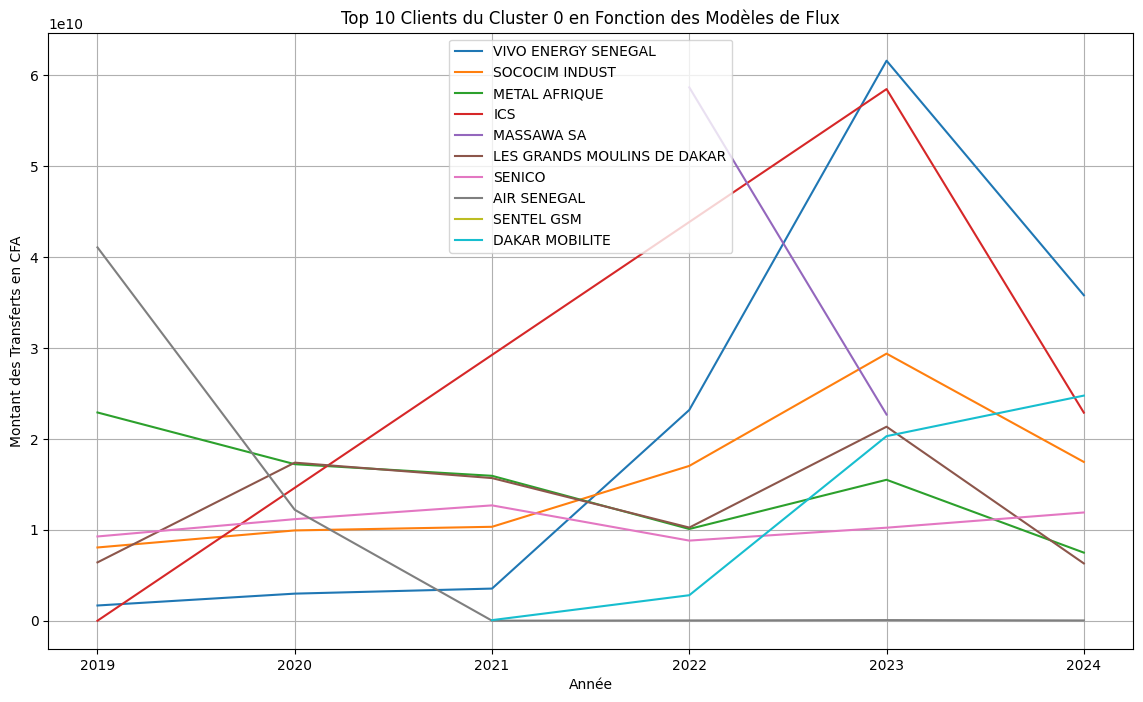

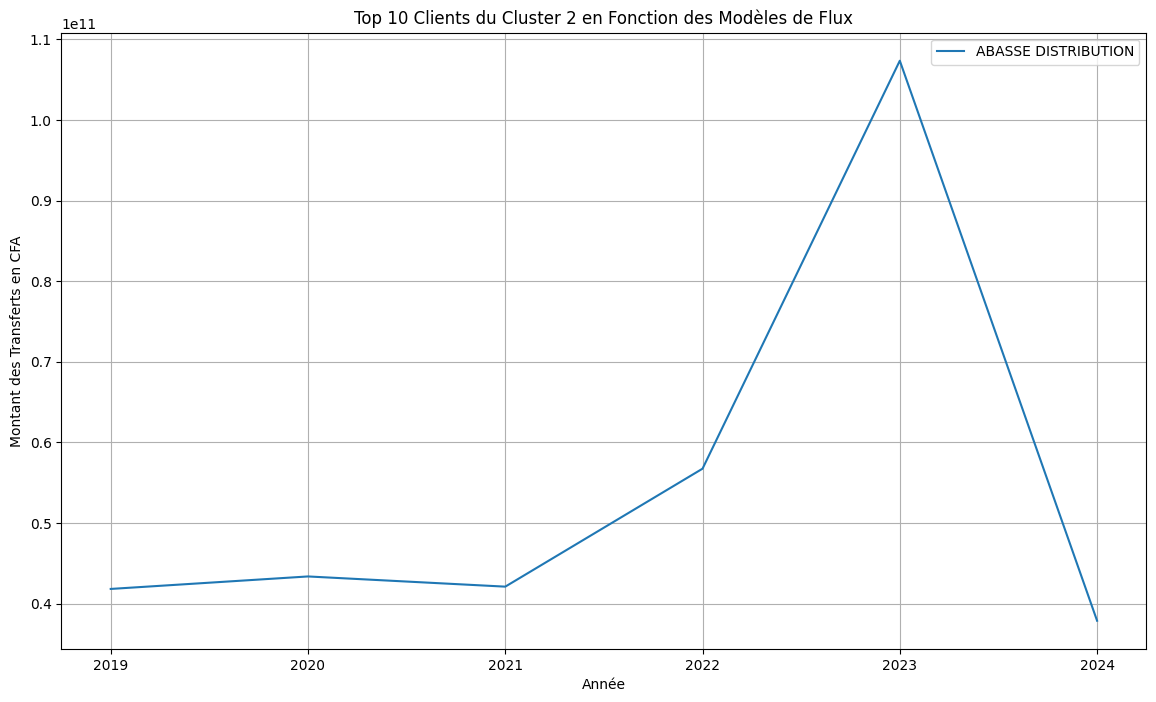

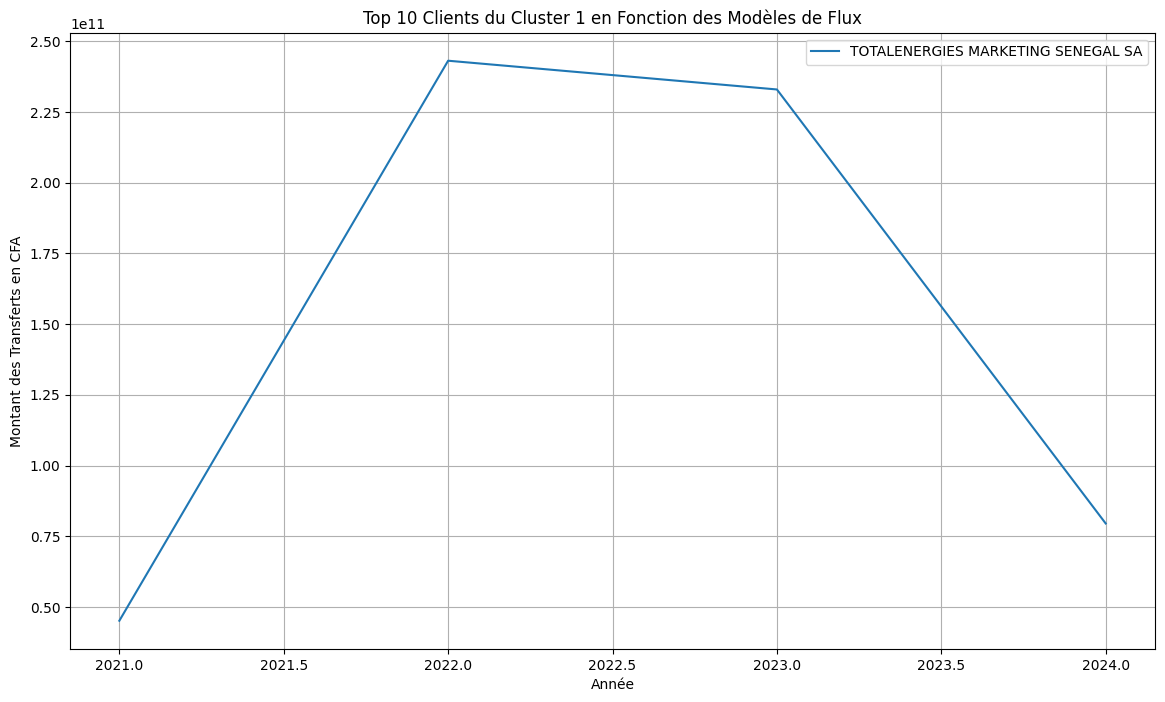

In [16]:
# Préparer les données pour les graphiques
top_10_flux_annuels = flux_annuels[flux_annuels['nomdo'].isin([client for sublist in top_10_clients_per_cluster.values() for client in sublist])]

# Visualiser les flux annuels pour les top 10 clients de chaque cluster
for cluster, top_10_clients in top_10_clients_per_cluster.items():
    plt.figure(figsize=(14, 8))
    for client in top_10_clients:
        client_data = top_10_flux_annuels[top_10_flux_annuels['nomdo'] == client]
        plt.plot(client_data['année'], client_data['mcfa'], label=client)
    plt.xlabel('Année')
    plt.ylabel('Montant des Transferts en CFA')
    plt.title(f'Top 10 Clients du Cluster {cluster} en Fonction des Modèles de Flux')
    plt.legend()
    plt.grid(True)
    plt.show()
